In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import plotly as py
!pip install chart_studio
import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 610.7 kB/s eta 0:00:00


In [2]:
data = pd.read_csv('city_day.csv')
print(data.head())

        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  


# **DATA PREPROCESSING**

In [9]:
def clean_data(data):
    """ Fill missing values with mean """
    data_cleaned = data.fillna(data.mean())
    return data_cleaned

data_cleaned = clean_data(data)

<ipython-input-9-c488b4264e19>:3: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [10]:
def transform_data(data):
    """ Scale data columns using MinMaxScaler """
    scaler = MinMaxScaler()
    cols_to_scale = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
    data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])
    return data

data_transformed = transform_data(data_cleaned)

# **FEATURE SELECTION**

In [11]:
def feature_engineering(data):
    """ Create a new feature combining two pollutants """
    data['Feature_PM2.5_PM10'] = data['PM2.5'] + data['PM10']
    return data

data_engineered = feature_engineering(data_transformed)

In [77]:
from google.colab import drive
drive.mount("/drive")
def handle_outliers(data, column):
    """ Remove outliers based on IQR for a given column """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

data_without_outliers = handle_outliers(data_engineered, 'PM2.5')

data_without_outliers.to_csv('preprocessed.csv')

Mounted at /drive


# **Data Visualization - Creating Correlation using heatmap**

<ipython-input-23-1cc02b25b166>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

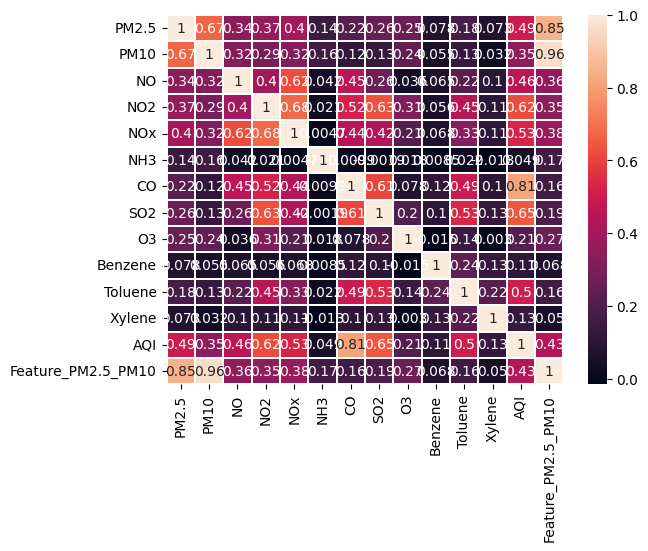

In [23]:
# we use coorelation to find the relation between the one variable to itself.

sns.heatmap(data_without_outliers.corr(),annot = True, linewidths = 0.1 )

In [24]:
city_annual_avg=data_without_outliers.copy()
city_annual_avg['Date'] = pd.to_datetime(city_annual_avg['Date'])
city_annual_avg=city_annual_avg.groupby(['City', city_annual_avg.Date.dt.year]).mean().reset_index().rename(columns={'Date':'Year'})
city_annual_avg
#Data correlations
city_annual_avg.corr().style.background_gradient(cmap='Oranges')

<ipython-input-24-d3b8f72f5bbc>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-24-d3b8f72f5bbc>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Year,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Feature_PM2.5_PM10
Year,1.000000,-0.520251,-0.568614,-0.171925,-0.147509,-0.196362,-0.294824,-0.113645,0.046990,-0.102683,-0.195726,-0.020976,-0.029938,-0.241754,-0.567495
PM2.5,-0.520251,1.000000,0.884813,0.560934,0.449679,0.525085,0.240727,0.275729,0.291759,0.411336,0.075901,0.337712,-0.035578,0.583243,0.946003
PM10,-0.568614,0.884813,1.000000,0.605534,0.412201,0.467150,0.367087,0.171052,0.181780,0.409487,0.088454,0.307979,-0.023568,0.469364,0.988076
NO,-0.171925,0.560934,0.605534,1.000000,0.559249,0.611520,0.169661,0.424707,0.447501,0.063481,0.198519,0.446875,0.331854,0.578310,0.606624
NO2,-0.147509,0.449679,0.412201,0.559249,1.000000,0.694902,0.030662,0.730381,0.768450,0.492956,0.072030,0.699241,0.107622,0.819461,0.435359
NOx,-0.196362,0.525085,0.467150,0.611520,0.694902,1.000000,-0.026051,0.509471,0.488222,0.387132,0.099497,0.512338,0.269741,0.664735,0.498504
NH3,-0.294824,0.240727,0.367087,0.169661,0.030662,-0.026051,1.000000,0.063880,0.015136,-0.014159,-0.001428,0.083585,-0.041831,0.132576,0.334928
CO,-0.113645,0.275729,0.171052,0.424707,0.730381,0.509471,0.063880,1.000000,0.933714,0.098823,0.379452,0.852739,0.202017,0.929730,0.210112
SO2,0.046990,0.291759,0.181780,0.447501,0.768450,0.488222,0.015136,0.933714,1.000000,0.224584,0.258759,0.860176,0.093730,0.901506,0.222873
O3,-0.102683,0.411336,0.409487,0.063481,0.492956,0.387132,-0.014159,0.098823,0.224584,1.000000,-0.300592,0.198023,-0.343989,0.293760,0.420801


r-values greater than 0.7 indicate a strong correlation. Therefore, it would be reasonable to say there is a strong correlation between the following:-



*   AQI : NO2 (0.78)
*   SO2 : CO (0.76)
*   NOx : NO (0.75)
*   AQI : CO (0.73)
*   AQI : SO2 (0.72)
*   AQI : PM2.5 (0.71)


Without considering the AQI, the pollutants with a strong correlation are SO2 and CO, and NOx and NO.

In [13]:
def feature_selection(data):
    """ Select features based on correlation with target variable AQI """
    correlation = data.corr()['AQI'].sort_values(ascending=False)
    features = correlation[correlation > 0.5].index.tolist()
    features.remove('AQI')
    return features

selected_feature = feature_selection(data_without_outliers)

<ipython-input-13-ed58d41e98bc>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



# **Plot Information about the count of AQI basket**

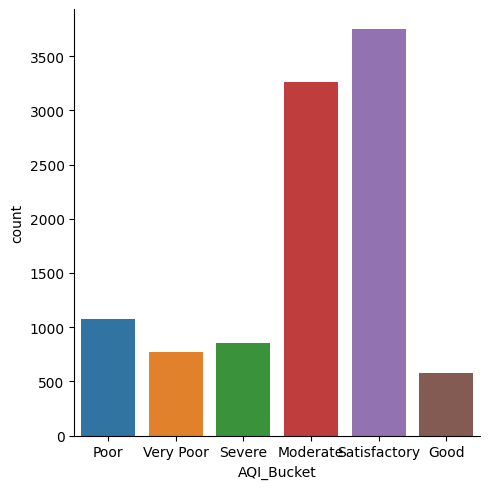

In [14]:
plot1 = sns.catplot(x="AQI_Bucket",data=data,kind="count")

# **Finding the number of reading with respect with each City.**

In [15]:
city_readings = data['City'].value_counts().to_frame().reset_index().rename(columns={'index':'City Name', 'City':'No. of readings'})
print(city_readings)

       City Name  No. of readings
0      Ahmedabad             2009
1      Bengaluru             2009
2        Chennai             2009
3          Delhi             1464
4       Amritsar             1221
5      Amaravati              951
6   Brajrajnagar              938
7     Coimbatore              386
8     Chandigarh              304
9         Bhopal              289
10        Aizawl              113


In [16]:
fig = px.bar(city_readings, x="City Name", y="No. of readings")
fig.show()

# **Ploting the bar plot to find the scewness in the data set...**

Skewness is a measurement of the distortion of symmetrical distribution or asymmetry in a data set. **bold text**

<ipython-input-18-79ba1d843611>:4: FutureWarning:

The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 0, 'Features')

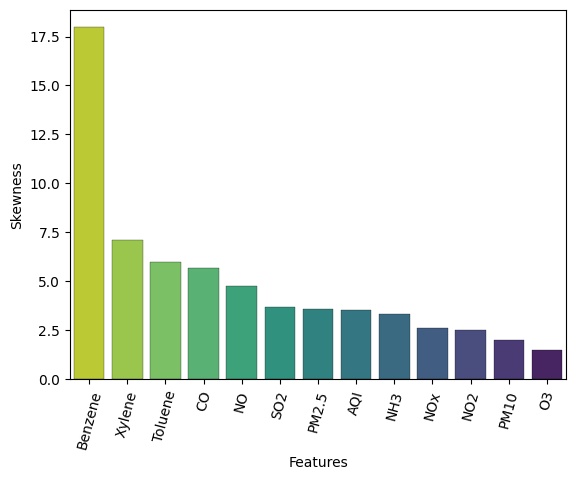

In [18]:
#analyzing skewness in data
#here we observe high skewness in Bezene,Toluene,CO and Xylene

skew=pd.DataFrame(data.skew().sort_values(ascending=False))
skew.columns=['Skewness']

plt.xticks(rotation=75)
sns.barplot(x=skew.index,y='Skewness',data=skew,
            edgecolor='black',
            linewidth=0.2,
            palette='viridis_r')
plt.xlabel('Features')

# **Plot Average readings for AQI across all cities (pie chart)**

In [21]:
avg_readings = data.groupby('City').mean().reset_index().round(2)
avg_readings

# avg readings for AQI across all cities (pie chart)
trace13=go.Pie(labels=avg_readings['City'], values=avg_readings['AQI'],
             title='Average AQI readings by City')
fig=go.Figure(trace13)
fig.update_traces(textposition='inside')
fig=fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

<ipython-input-21-677cb8991d3f>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



# **MODEL TRAINING**

In [25]:
# Split data
X = data_without_outliers[selected_feature]
y = data_without_outliers['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression().fit(X_train, y_train)
lr.fit(X_train, y_train)

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

gb = GradientBoostingRegressor().fit(X_train, y_train)
gb.fit(X_train, y_train)

svr = SVR().fit(X_train, y_train)
svr.fit(X_train, y_train)

SVR()

In [39]:

lr_predictions = lr.predict(X_test)
print("Linear Regression MSE :  ", mean_squared_error(y_test,lr_predictions))

rf_predictions = best_rf.predict(X_test)
print("Random Forest MSE :  ", mean_squared_error(y_test, rf_predictions))

gb_predictions = gb.predict(X_test)
print("Gradient Boosting MSE :  ", mean_squared_error(y_test, gb_predictions))

svr_predictions = svr.predict(X_test)
print("SVR MSE :  ", mean_squared_error(y_test, svr_predictions))




Linear Regression MSE :   0.0015420217606865261
Random Forest MSE :   0.0009892907984513967
Gradient Boosting MSE :   0.0010891979846405192
SVR MSE :   0.003993961663292951


# **ACCURACY SCORE AND CONFUSION MATRIX**

In [61]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
df = data_without_outliers.copy()
categorical_attributes = list(df.select_dtypes(include=['object']).columns)
categorical_attributes

df=pd.read_csv('city_day.csv',parse_dates=['Date'])
raw_df = df

df['Date'] = pd.to_datetime(df['Date'])

df.info()

df['PM2.5']=df['PM2.5'].fillna((df['PM2.5'].median()))
df['PM10']=df['PM10'].fillna((df['PM10'].median()))
df['NO']=df['NO'].fillna((df['NO'].median()))
df['NO2']=df['NO2'].fillna((df['NO2'].median()))
df['NOx']=df['NOx'].fillna((df['NOx'].median()))
df['NH3']=df['NH3'].fillna((df['NH3'].median()))
df['CO']=df['CO'].fillna((df['CO'].median()))
df['SO2']=df['SO2'].fillna((df['SO2'].median()))
df['O3']=df['O3'].fillna((df['O3'].median()))
df['Benzene']=df['Benzene'].fillna((df['Benzene'].median()))
df['Toluene']=df['Toluene'].fillna((df['Toluene'].median()))
df['Xylene']=df['Xylene'].fillna((df['Xylene'].median()))
df['AQI']=df['AQI'].fillna((df['AQI'].median()))
df['AQI_Bucket']=df['AQI_Bucket'].fillna('Moderate')

df1 = df
df.head()

df = df[df['Date'] <= ('25-03-2020')]
df['Vehicular Pollution content'] = df['PM2.5']+df['PM10']+df['NO']+df['NO2']+df['NOx']+df['NH3']+df['CO']
df['Industrial Pollution content'] = df['SO2']+df['O3']+df['Benzene']+df['Toluene']+df['Xylene']
df = df.drop(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3','Benzene','Toluene','Xylene'],axis=1)
df.info()

df = df1.copy()
categorical_attributes = list(df.select_dtypes(include=['object']).columns)
categorical_attributes

le=LabelEncoder()
df['City']=le.fit_transform(df['City'].astype(str))
df['AQI_Bucket']=le.fit_transform(df['AQI_Bucket'].astype(str))
df.info()

y = df["AQI_Bucket"]
x = df[['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print('Classes and number of values in trainset',Counter(y_train))

df.AQI_Bucket.unique()

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)
print('Classes and number of values in trainset after SMOTE:',Counter(y_train))

cls=SVC()
cls.fit(X_train,y_train)
svmpred=cls.predict(X_test)
accuracy=accuracy_score(y_test,svmpred)*100
print("SVM Accuracy = ",accuracy)

cm=confusion_matrix(y_test,svmpred)
print("SVM Confusion matrix\n")
print(cm)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       24933 non-null  float64       
 3   PM10        18391 non-null  float64       
 4   NO          25949 non-null  float64       
 5   NO2         25946 non-null  float64       
 6   NOx         25346 non-null  float64       
 7   NH3         19203 non-null  float64       
 8   CO          27472 non-null  float64       
 9   SO2         25677 non-null  float64       
 10  O3          25509 non-null  float64       
 11  Benzene     23908 non-null  float64       
 12  Toluene     21490 non-null  float64       
 13  Xylene      11422 non-null  float64       
 14  AQI         24850 non-null  float64       
 15  AQI_Bucket  24850 non-null  object        
dtypes: datetime64[ns](1), 

<ipython-input-61-0598873fb9f1>:37: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

<ipython-input-61-0598873fb9f1>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-61-0598873fb9f1>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  int64         
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       29531 non-null  float64       
 3   PM10        29531 non-null  float64       
 4   NO          29531 non-null  float64       
 5   NO2         29531 non-null  float64       
 6   NOx         29531 non-null  float64       
 7   NH3         29531 non-null  float64       
 8   CO          29531 non-null  float64       
 9   SO2         29531 non-null  float64       
 10  O3          29531 non-null  float64       
 11  Benzene     29531 non-null  float64       
 12  Toluene     29531 non-null  float64       
 13  Xylene      29531 non-null  float64       
 14  AQI         29531 non-null  float64       
 15  AQI_Bucket  29531 non-null  int64         
dtypes: datetime64[ns](1), 

In [64]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [73]:
# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy = accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

print("Random Forest Accuracy = ",accuracy)

confusion=confusion_matrix(y_test,svmpred)
print("Random Forest Confusion matrix\n",confusion )

Random Forest Accuracy =  0.999661418655832
Random Forest Confusion matrix
 [[ 262    0    0    0    0    0]
 [   0 2651   52   58    0    0]
 [   0    0  564    0    0   14]
 [  84    1    0 1489    0    0]
 [   0    0    0    0  248    1]
 [   0    0    1    0    7  475]]


In [74]:
from sklearn.ensemble import GradientBoostingClassifier
grad_booster = GradientBoostingClassifier()

grad_booster.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = grad_booster.predict(X_test)

# View accuracy score
accuracy = accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

print("Gradient Boosting Accuracy = ",accuracy)

confusion=confusion_matrix(y_test,svmpred)
print("Gradient Boosting Confusion matrix\n",confusion )






Gradient Boosting Accuracy =  1.0
Gradient Boosting Confusion matrix
 [[ 262    0    0    0    0    0]
 [   0 2651   52   58    0    0]
 [   0    0  564    0    0   14]
 [  84    1    0 1489    0    0]
 [   0    0    0    0  248    1]
 [   0    0    1    0    7  475]]
